**CNN**

1. Import and become one with the data

In [1]:
import zipfile
import os
import urllib.request

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
filename = "pizza_steak.zip"

if not os.path.exists(filename):
    print("Se descarca datele...")
    urllib.request.urlretrieve(url, filename)
    print("Descărcare completa.")
else:
    print("Fișierul exista deja.")
    
if not os.path.exists(filename):
    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall()
#zipfile.ZipExtFile(filename)
#print("Se dezarhiveaza...")
#zip_ref = zipfile.ZipFile(filename, "r")
#zip_ref.extractall()
#zip_ref.close()

Fișierul exista deja.


In [2]:
import zipfile
import os
import urllib.request
num_steak_nr=len(os.listdir("./pizza_steak/train/steak"))
print(f"There are {num_steak_nr} numbers of images ")

for path,dir,file in os.walk("pizza_steak"):
    print(f"There are {len(dir)} directories and {len(file)} images in {path}")

There are 750 numbers of images 
There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak\test
There are 0 directories and 250 images in pizza_steak\test\pizza
There are 0 directories and 250 images in pizza_steak\test\steak
There are 2 directories and 0 images in pizza_steak\train
There are 0 directories and 750 images in pizza_steak\train\pizza
There are 0 directories and 750 images in pizza_steak\train\steak


In [3]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,sub_directory,target_class):
    folder=target_dir+"/"+sub_directory+"/"+target_class
    
    #random_image=random.sample(os.listdir(folder),1)
    #img=mpimg.imread(folder+"/"+random_image[0]) // random_image[0]->pt ca returneaza o lista de imagini chiar daca e o singura imagine pentru am specificat mai sus 1
    
    random_image=random.choice(os.listdir(folder))
    img=mpimg.imread(folder+"/"+random_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis(False)
    print(f"Image shape: {img.shape}")
    return img

Image shape: (384, 512, 3)


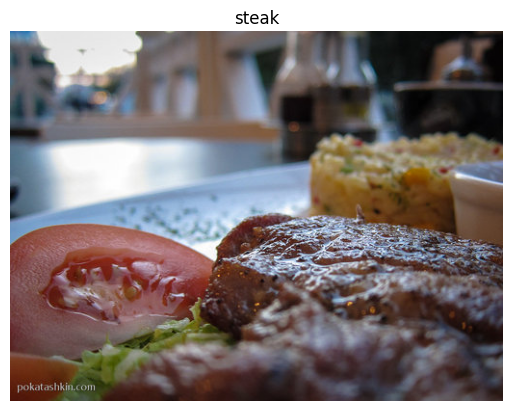

In [4]:
image=view_random_image("pizza_steak","train","steak")

In [5]:
image

array([[[ 49, 113, 175],
        [ 51, 112, 175],
        [ 52, 112, 175],
        ...,
        [ 46,  36,  27],
        [ 43,  33,  24],
        [ 41,  31,  22]],

       [[ 54, 119, 173],
        [ 57, 120, 174],
        [ 58, 119, 174],
        ...,
        [ 39,  30,  23],
        [ 36,  27,  20],
        [ 34,  25,  18]],

       [[ 65, 128, 172],
        [ 66, 129, 173],
        [ 67, 128, 173],
        ...,
        [ 30,  22,  19],
        [ 28,  20,  17],
        [ 26,  18,  15]],

       ...,

       [[ 79,  23,  10],
        [ 79,  23,  10],
        [ 79,  23,  10],
        ...,
        [ 52,  34,  32],
        [ 51,  33,  31],
        [ 50,  32,  30]],

       [[ 78,  21,  10],
        [ 78,  21,  10],
        [ 78,  21,  10],
        ...,
        [ 54,  39,  36],
        [ 52,  37,  34],
        [ 51,  36,  33]],

       [[ 76,  19,   8],
        [ 77,  20,   9],
        [ 77,  20,   9],
        ...,
        [ 56,  42,  41],
        [ 53,  39,  38],
        [ 51,  37,  36]]

2. Preprocess the data

In [6]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)
# Cream generatoare de date cu rescaling (normalizare)
# Rescale=1./255 imparte fiecare pixel la 255 pentru a avea valori intre 0 si 1.

train_data_generator=ImageDataGenerator(rescale=1./255)
test_data_generator=ImageDataGenerator(rescale=1./255)

train_path="pizza_steak/train/"
test_path="pizza_steak/test/"
# Incarcam imaginile din directoare si le organizam in batch-uri
train_data=train_data_generator.flow_from_directory(train_path,
                                                    batch_size=32,# Procesam cate 32 de imagini o data
                                                    target_size=(224,224),
                                                    # Redimensionam toate imaginile la 224x224
                                                    class_mode="binary",
                                                    seed=42)

test_data=test_data_generator.flow_from_directory(test_path,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  class_mode='binary',
                                                  seed=42)

model_1=tf.keras.Sequential([
    # Primul bloc convolutional
  # filters=10: Modelul va invata 10 filtre (trasaturi) diferite
  # kernel_size=3: Filtrul este o matrice 3x3
  # activation='relu': Introduce non-linearitate (valori negative devin 0)
  # input_shape=(224, 224, 3): Specificam forma input-ului doar la primul strat
    tf.keras.layers.Conv2D( filters=10, 
                            kernel_size=3,
                            activation='relu',
                            input_shape=[224,224,3]),
    tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
    # MaxPool2D reduce dimensiunea imaginii la jumatate (ia max din 2x2)
    tf.keras.layers.MaxPool2D(pool_size=2,
                          padding='valid' # daca imaginea nu se imparte exact la 2,2 imi ginora marginile  
                          ), 
    tf.keras.layers.Conv2D(filters=10,
                           activation='relu',
                           kernel_size=3),
    tf.keras.layers.Conv2D(filters=10,
                           activation='relu', # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
                           kernel_size=3),
    tf.keras.layers.MaxPool2D(pool_size=2),
    # Transforma volumul 3D intr-un vector 1D
    tf.keras.layers.Flatten(),
    # 1 neuron, sigmoid returneaza probabilitate (0-1)
    tf.keras.layers.Dense(1,activation='sigmoid') 
])

model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_1=model_1.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data # Evaluam pe setul de testare
                      ,validation_steps=len(test_data))   

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


C:\Users\darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.5413 - loss: 0.7006 - val_accuracy: 0.7380 - val_loss: 0.6042
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.7293 - loss: 0.5616 - val_accuracy: 0.8020 - val_loss: 0.4641
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.7920 - loss: 0.4667 - val_accuracy: 0.8460 - val_loss: 0.3863
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.7853 - loss: 0.4522 - val_accuracy: 0.8580 - val_loss: 0.3717
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.8187 - loss: 0.4050 - val_accuracy: 0.8540 - val_loss: 0.3499


We can do the evaluation when we fit the model 
**1.model_1.fit(validation_data=test_data,validation_step=len(test_data)**
**2.model_1.evaluate(test_data)**   

In [7]:
model_1.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8540 - loss: 0.3499


[0.34987562894821167, 0.8539999723434448]

In [8]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

In [9]:
def plot_loss_curves(history_1):
    loss=history_1.history['loss']
    val_loss=history_1.history['val_loss']
    
    accuracy=history_1.history['accuracy']
    val_accuracy=history_1.history['val_accuracy']
    
    epochs=range(len(history_1.history['loss']))
    plt.plot(epochs,loss,label='training_loss')
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('loss')
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs,accuracy,label='training_accuracy')
    plt.plot(epochs,val_accuracy,label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    

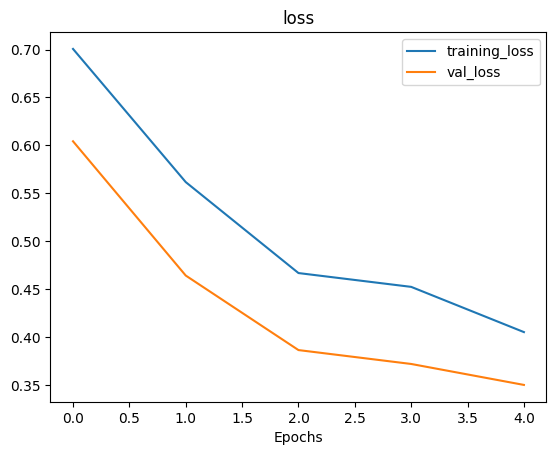

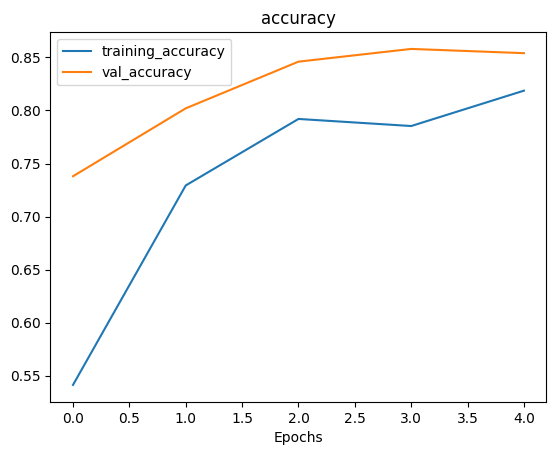

In [10]:
plot_loss_curves(history_1)

In [11]:
model_2=tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        input_shape=(224,224,3),
        activation='relu',
    ),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_2=model_2.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6647 - loss: 0.6153 - val_accuracy: 0.7600 - val_loss: 0.4914
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7807 - loss: 0.4794 - val_accuracy: 0.7820 - val_loss: 0.4449
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8187 - loss: 0.4162 - val_accuracy: 0.8500 - val_loss: 0.3561
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8353 - loss: 0.3850 - val_accuracy: 0.8560 - val_loss: 0.3365
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8427 - loss: 0.3814 - val_accuracy: 0.7700 - val_loss: 0.4640


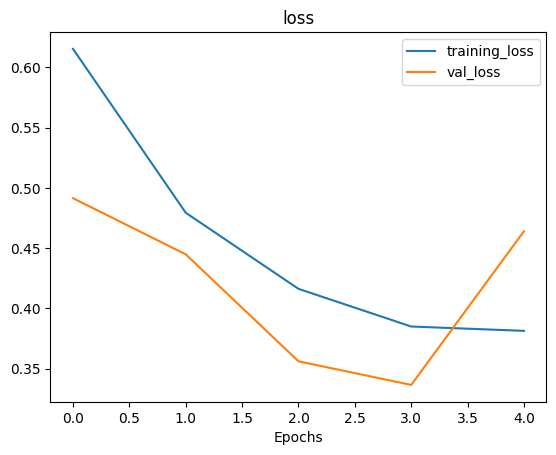

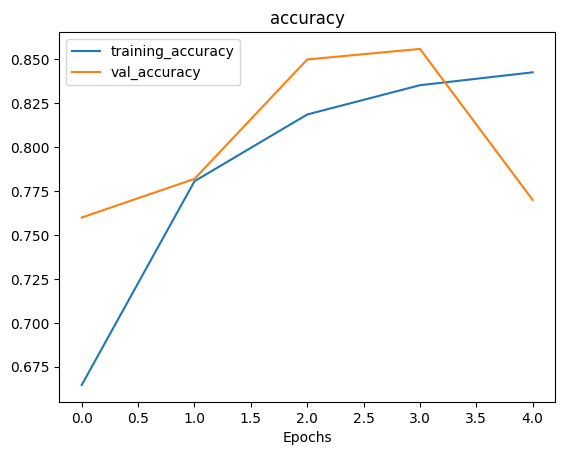

In [12]:
plot_loss_curves(history_2)

In [13]:
model_2.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7700 - loss: 0.4640


[0.46398812532424927, 0.7699999809265137]

In [14]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

In [15]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [16]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data_aug = train_datagen.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(train_path,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 1500 images belonging to 2 classes.


In [17]:
# Get data batch samples
images, labels = next(train_data_aug)
augmented_images, augmented_labels = next(train_data_augmented)
train_data_aug

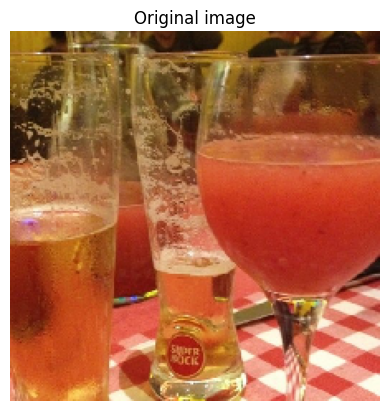

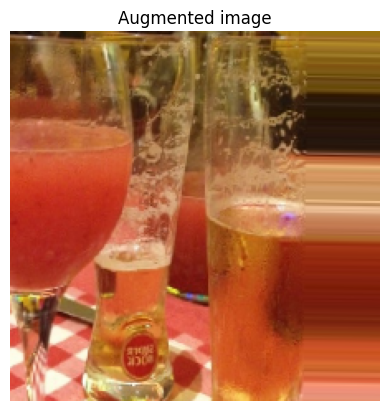

In [18]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [19]:
model_3=tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        input_shape=(224,224,3),
        activation='relu',
    ),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_3=model_3.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.4840 - loss: 0.6999 - val_accuracy: 0.7113 - val_loss: 0.6835
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.6000 - loss: 0.6777 - val_accuracy: 0.7653 - val_loss: 0.6062
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.6087 - loss: 0.6681 - val_accuracy: 0.6767 - val_loss: 0.5881
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.6320 - loss: 0.6379 - val_accuracy: 0.5833 - val_loss: 0.6583
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.6260 - loss: 0.6457 - val_accuracy: 0.7307 - val_loss: 0.6279


Our model perform bad because the data is not shuffled and that means he sees a bath of a single kind of images.

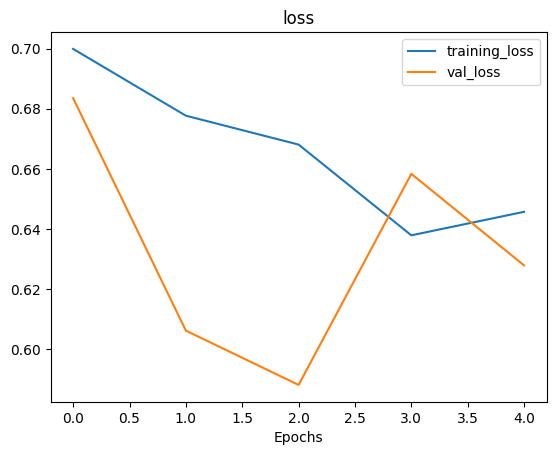

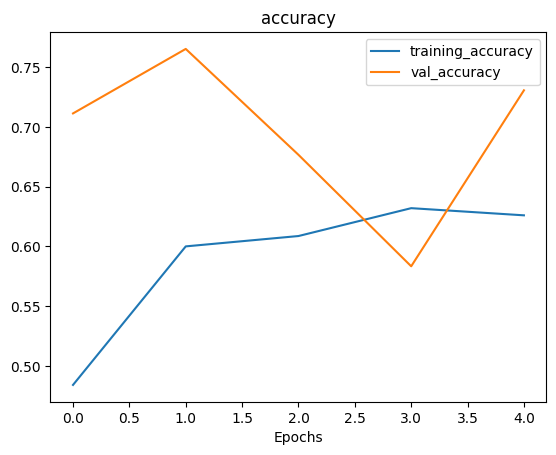

In [20]:
plot_loss_curves(history_3)

In [21]:
model_3.evaluate(test_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7307 - loss: 0.6279


[0.6278789639472961, 0.7306666374206543]

In [22]:
train_data_augmented_shuffle=train_datagen_augmented.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
) 

Found 1500 images belonging to 2 classes.


In [23]:
model_4=tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        input_shape=(224,224,3),
        activation='relu',
    ),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_4=model_4.fit(train_data_augmented_shuffle,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - accuracy: 0.5753 - loss: 0.6814 - val_accuracy: 0.7453 - val_loss: 0.6002
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.7273 - loss: 0.5469 - val_accuracy: 0.7727 - val_loss: 0.4869
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.7747 - loss: 0.4823 - val_accuracy: 0.7993 - val_loss: 0.4248
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.7813 - loss: 0.4684 - val_accuracy: 0.8200 - val_loss: 0.4060
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - accuracy: 0.7980 - loss: 0.4428 - val_accuracy: 0.8287 - val_loss: 0.3933


In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_prep_image(filename,input_shape=224):
    img=tf.io.read_file(filename)
    
    image = tf.image.decode_image(img, channels=3)
    
    image=tf.image.resize(image,size=[input_shape,input_shape])
    
    image=image/255.
    
    return image

In [25]:
load_and_prep_image('pizza_steak/train/steak/3136.jpg')

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], shape=(224, 224, 3), dtype=float32)>

In [28]:
steak = mpimg.imread("pizza_steak/train/steak/3136.jpg")
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (354, 512, 3)
Shape after new dimension: (1, 354, 512, 3)


<tf.Tensor: shape=(1, 354, 512, 3), dtype=uint8, numpy=
array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], shape=(1, 354, 512, 3), dtype=uint8)>

In [30]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [31]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


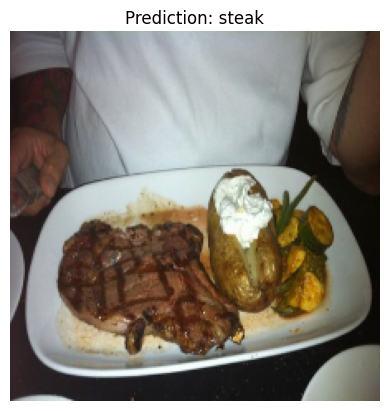

In [50]:
pred_and_plot(model_4, "pizza_steak/train/steak/100135.jpg", class_names)